In [1]:
from weighted_model.fair_teacher_student_classifier import FairTeacherStudentClassifier
from weighted_model.teacher_student_classifier import TeacherStudentClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from fairlearn.datasets import fetch_adult
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

In [2]:
data = fetch_adult(as_frame=True)
df = data.frame
print(len(df))
df.head()


48842


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


race                class
Amer-Indian-Eskimo  <=50K    0.882979
                    >50K     0.117021
Asian-Pac-Islander  <=50K    0.730744
                    >50K     0.269256
Black               <=50K    0.879189
                    >50K     0.120811
Other               <=50K    0.876847
                    >50K     0.123153
White               <=50K    0.746013
                    >50K     0.253987
Name: proportion, dtype: float64


C:\Users\trdin\AppData\Local\Temp\ipykernel_29004\2974537177.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('race')['class'].value_counts(normalize=True))


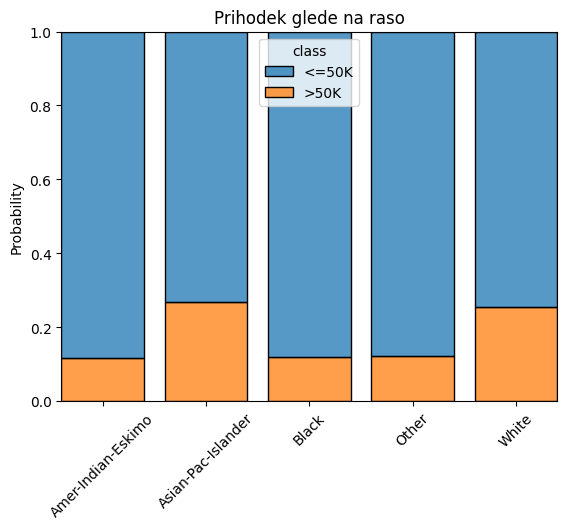

In [3]:
import matplotlib.pyplot as plt
print(df.groupby('race')['class'].value_counts(normalize=True))

sns.histplot(data=df, x='race', hue='class', stat='probability', multiple='fill', shrink=.8)
plt.title("Prihodek glede na raso")
plt.xticks(rotation=45)
plt.xlabel(None)
plt.show()

In [4]:
# Load dataset
data = fetch_adult(as_frame=True)
df = data.frame

# Preprocessing: Encode categorical variables
label_encoders = {}
for col in ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Features and labels
X = df.drop(columns=['class'])
y = (df['class'] == '>50K').astype(int)  # Binary target: 1 if >50K, else 0
z = df['race']  # Sensitive attribute

# Train-test split
X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(X, y, z, test_size=0.2, random_state=42, stratify=y)


In [10]:

fair_classifier_mode_0 = FairTeacherStudentClassifier(RandomForestClassifier)
fair_classifier_mode_1 = FairTeacherStudentClassifier(RandomForestClassifier)
baseline_model = TeacherStudentClassifier(RandomForestClassifier)

fair_classifier_split_mode_0 = FairTeacherStudentClassifier(RandomForestClassifier, split_data=True)
fair_classifier_split_mode_1 = FairTeacherStudentClassifier(RandomForestClassifier, split_data=True)
baseline_split = TeacherStudentClassifier(RandomForestClassifier, split_data=True)
#randomForrest for reference
rf_classifier = RandomForestClassifier()
RandomForestClassifier()

# Train classifiers
fair_classifier_mode_0.fit(X_train, y_train, z_train, mode=0)
fair_classifier_mode_1.fit(X_train, y_train, z_train, mode=1)
baseline_model.fit(X_train, y_train)

# Train clasifiers with split data
fair_classifier_split_mode_0.fit(X_train, y_train, z_train, mode=0)
fair_classifier_split_mode_1.fit(X_train, y_train, z_train, mode=1)
baseline_split.fit(X_train, y_train)

rf_classifier.fit(X_train, y_train)

# Predictions for intial models and baseline student teacher 
fair_predictions_mode_0 = fair_classifier_mode_0.predict(X_test)
fair_predictions_mode_1 = fair_classifier_mode_1.predict(X_test)
baseline_model_predictions= baseline_model.predict(X_test)

# Predictions for models with split learning dataset
fair_predictions_split_mode_0 = fair_classifier_split_mode_0.predict(X_test)
fair_predictions_split_mode_1 = fair_classifier_split_mode_1.predict(X_test)
baseline_split_predictions = baseline_split.predict(X_test)

rf_predictions = rf_classifier.predict(X_test)

Min accuracy group: 2
Min accuracy group: 1


{'Fair Classifier Mode 0': 0.8606817483877572, 'Fair Classifier Mode 1': 0.8599651960282526, 'Baseline Model': 0.8617053946156208, 'Fair Classifier Split Mode 0': 0.8607841130105436, 'Fair Classifier Split Mode 1': 0.8623195823523391, 'Baseline Split': 0.8606817483877572, 'Random Forest': 0.8619101238611936}


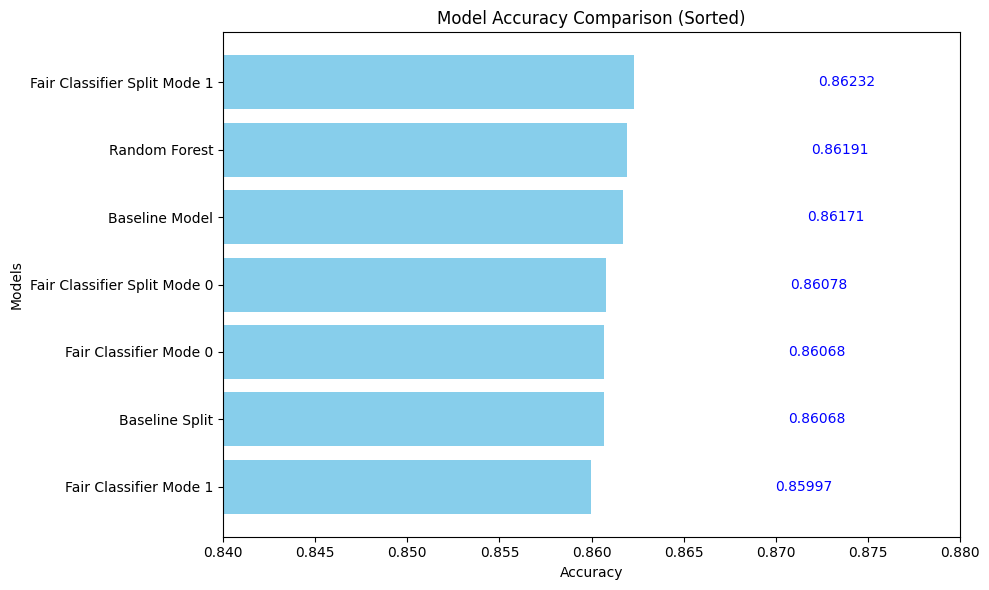

In [9]:
# Evaluate accuracy for each model
accuracies = {
    "Fair Classifier Mode 0": accuracy_score(y_test, fair_predictions_mode_0),
    "Fair Classifier Mode 1": accuracy_score(y_test, fair_predictions_mode_1),
    "Baseline Model": accuracy_score(y_test, baseline_model_predictions),
    "Fair Classifier Split Mode 0": accuracy_score(y_test, fair_predictions_split_mode_0),
    "Fair Classifier Split Mode 1": accuracy_score(y_test, fair_predictions_split_mode_1),
    "Baseline Split": accuracy_score(y_test, baseline_split_predictions),
    "Random Forest": accuracy_score(y_test, rf_predictions),
}

print(accuracies)

# Sort models by accuracy
sorted_accuracies = sorted(accuracies.items(), key=lambda x: x[1], reverse=True)

# Prepare data for plotting
models = [item[0] for item in sorted_accuracies]
accuracy_values = [item[1] for item in sorted_accuracies]

# Plot the sorted accuracies
plt.figure(figsize=(10, 6))
plt.barh(models, accuracy_values, color="skyblue")
plt.xlabel("Accuracy")
plt.ylabel("Models")
plt.title("Model Accuracy Comparison (Sorted)")
plt.gca().invert_yaxis()  # Invert y-axis to show highest accuracy at the top
plt.xlim(0.84, 0.88)


# Annotate bars with accuracy values
for i, v in enumerate(accuracy_values):
    plt.text(v + 0.01, i, f"{v:.5f}", color='blue', va='center')

plt.tight_layout()
plt.show()


In [11]:
# Compare accuracy by race
results = {}
for group in np.unique(z_test):
    mask = (z_test == group)
    
    # Calculate accuracy for each model
    fair_accuracy_mode_0 = accuracy_score(y_test[mask], fair_predictions_mode_0[mask])
    fair_accuracy_mode_1 = accuracy_score(y_test[mask], fair_predictions_mode_1[mask])
    fair_accuracy_split_mode_0 = accuracy_score(y_test[mask], fair_predictions_split_mode_0[mask])
    fair_accuracy_split_mode_1 = accuracy_score(y_test[mask], fair_predictions_split_mode_1[mask])
    baseline_accuracy = accuracy_score(y_test[mask], baseline_model_predictions[mask])
    baseline_split_accuracy = accuracy_score(y_test[mask], baseline_split_predictions[mask])
    rf_accuracy = accuracy_score(y_test[mask], rf_predictions[mask])
    
    # Add all model accuracies to the results dictionary
    results[label_encoders['race'].inverse_transform([group])[0]] = {
        'Fair Classifier Mode 0 Accuracy': fair_accuracy_mode_0,
        'Fair Classifier Mode 1 Accuracy': fair_accuracy_mode_1,
        'Fair Classifier Split Mode 0 Accuracy': fair_accuracy_split_mode_0,
        'Fair Classifier Split Mode 1 Accuracy': fair_accuracy_split_mode_1,
        'Baseline Accuracy': baseline_accuracy,
        'Baseline Split Accuracy': baseline_split_accuracy,
        'Random Forest Accuracy': rf_accuracy
    }

# Display results
results_df = pd.DataFrame(results).T
print(results_df)

                    Fair Classifier Mode 0 Accuracy  \
Amer-Indian-Eskimo                         0.916667   
Asian-Pac-Islander                         0.800643   
Black                                      0.918388   
Other                                      0.890244   
White                                      0.852984   

                    Fair Classifier Mode 1 Accuracy  \
Amer-Indian-Eskimo                         0.916667   
Asian-Pac-Islander                         0.813505   
Black                                      0.929752   
Other                                      0.926829   
White                                      0.852863   

                    Fair Classifier Split Mode 0 Accuracy  \
Amer-Indian-Eskimo                               0.916667   
Asian-Pac-Islander                               0.794212   
Black                                            0.916322   
Other                                            0.890244   
White                            

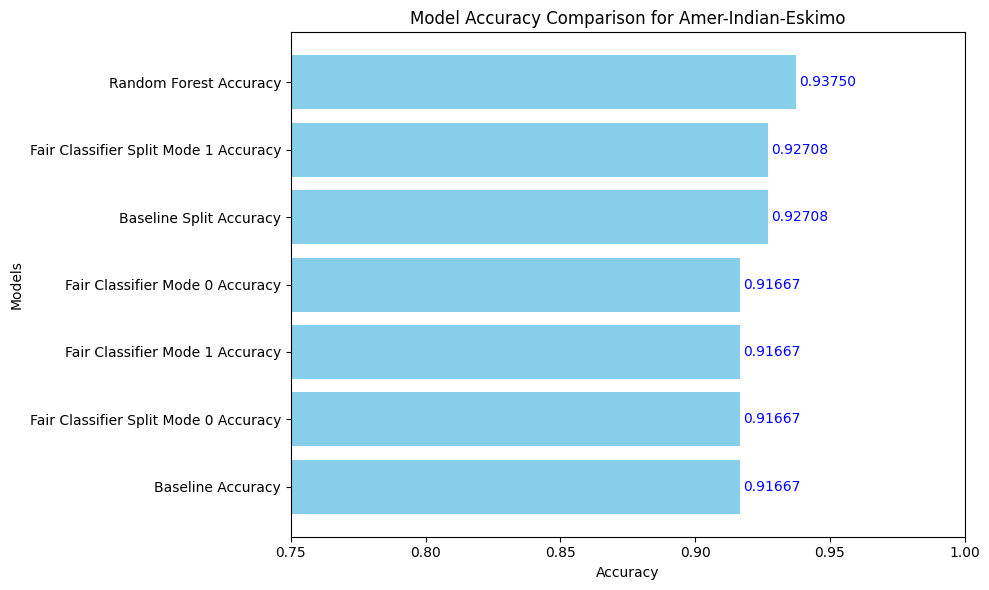

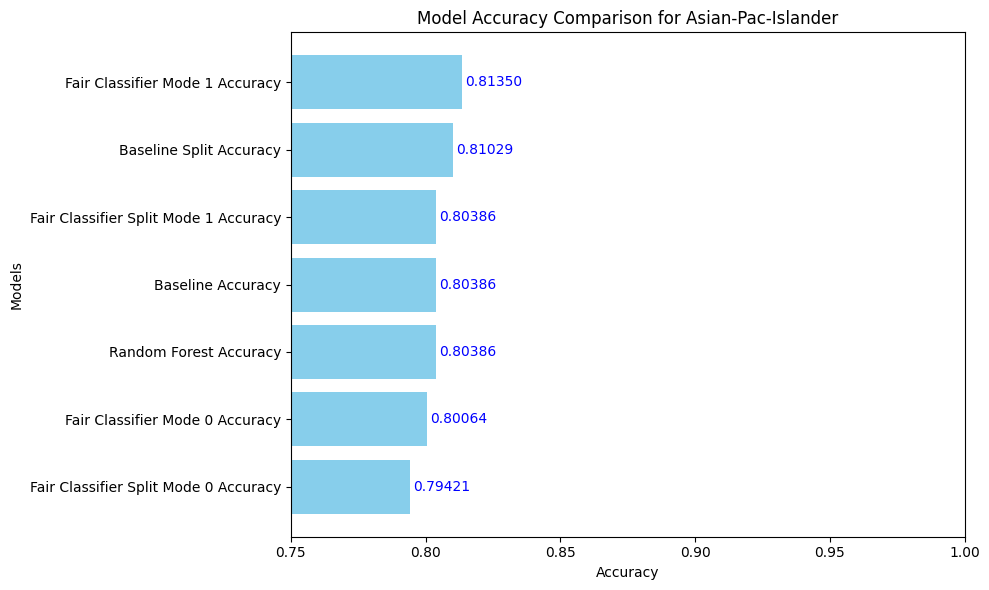

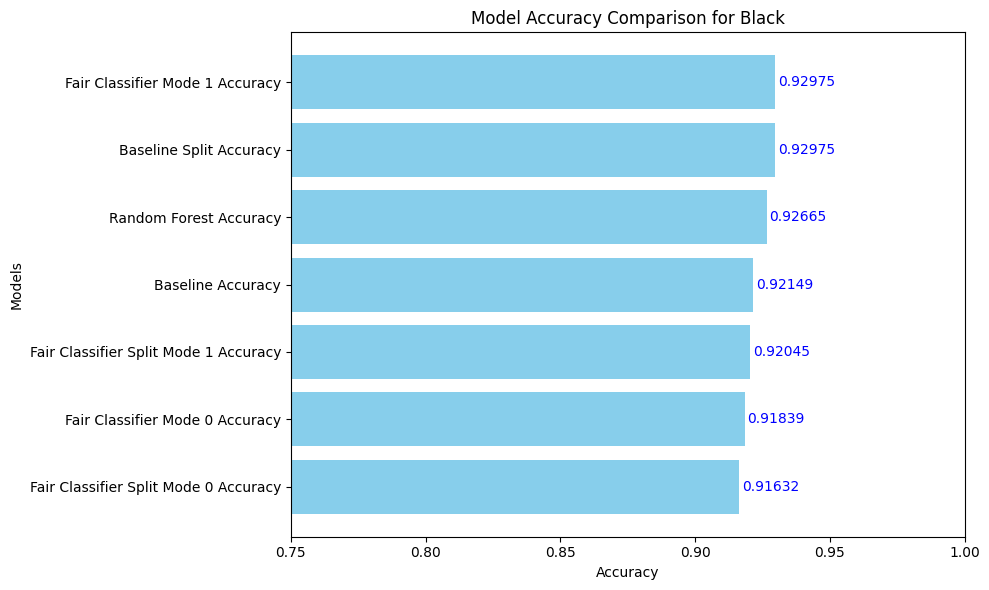

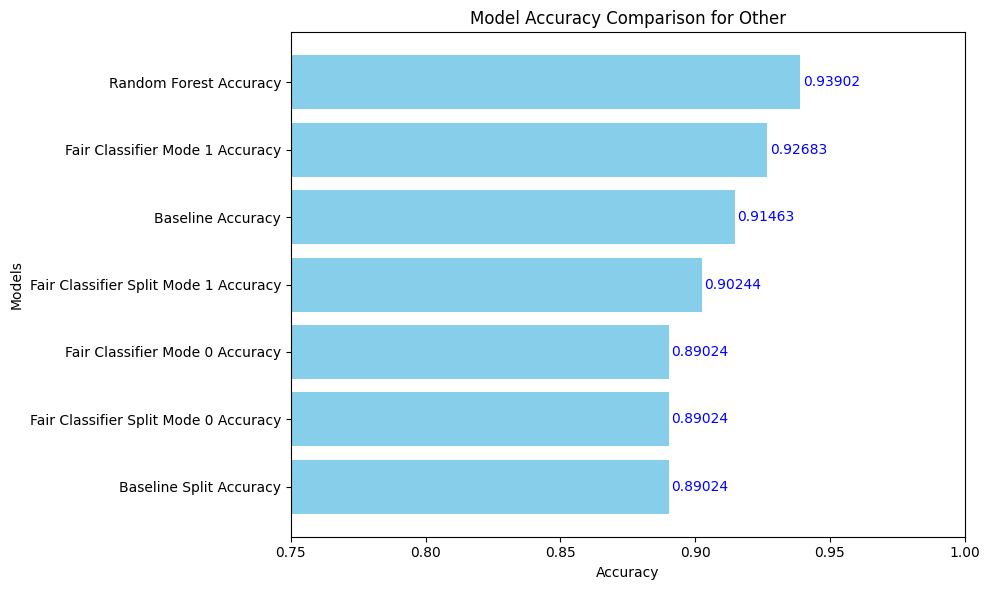

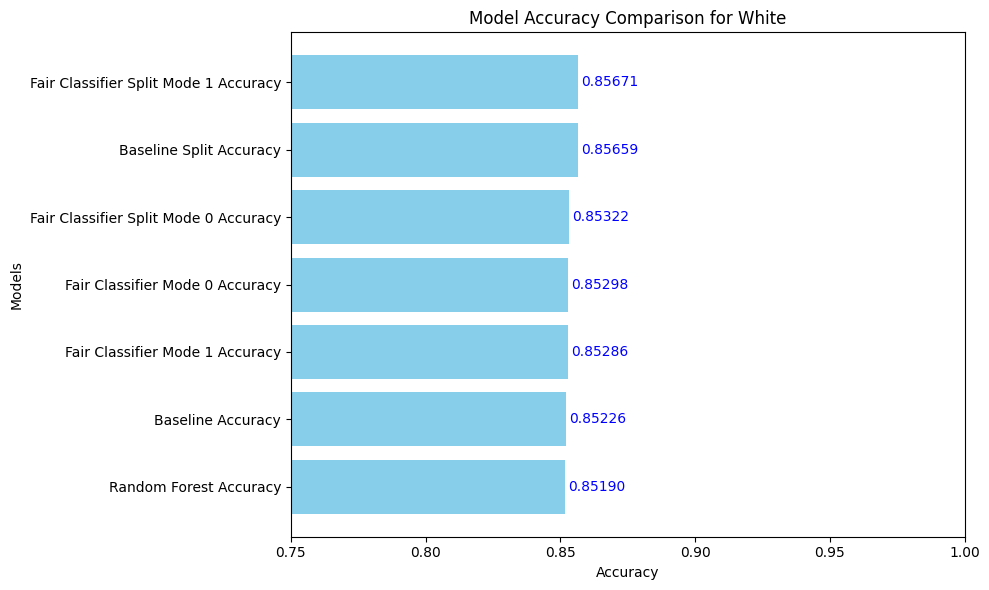

In [20]:
for race_group in results_df.index:
    # Get the accuracy values for this race group
    accuracies = results_df.loc[race_group]
    
    # Sort the accuracies in descending order
    accuracies_sorted = accuracies.sort_values(ascending=False)
    
    # Create the bar chart for this race group
    plt.figure(figsize=(10, 6))
    plt.barh(accuracies_sorted.index, accuracies_sorted.values, color="skyblue")
    plt.xlabel("Accuracy")
    plt.ylabel("Models")
    plt.title(f"Model Accuracy Comparison for {race_group}")
    plt.xlim(0.75, 1)  # Limiting accuracy between 0.8 and 0.9
    
    # Annotate bars with accuracy values
    for i, v in enumerate(accuracies_sorted.values):
        plt.text(v + 0.001, i, f"{v:.5f}", color='blue', va='center')

    # Invert y-axis to show the highest accuracy at the top
    plt.gca().invert_yaxis()
    
    # Display the plot
    plt.tight_layout()
    plt.show()

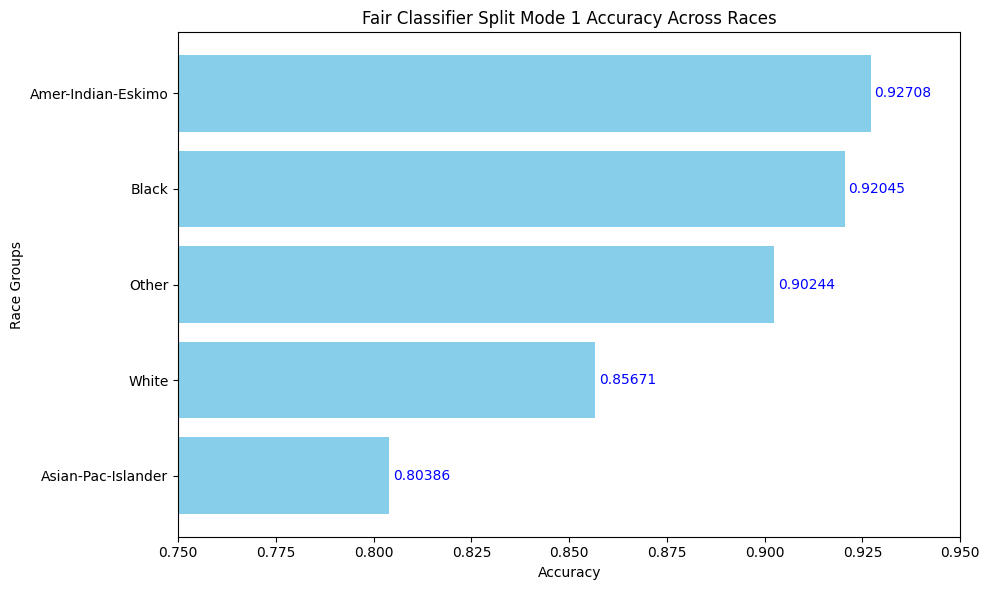

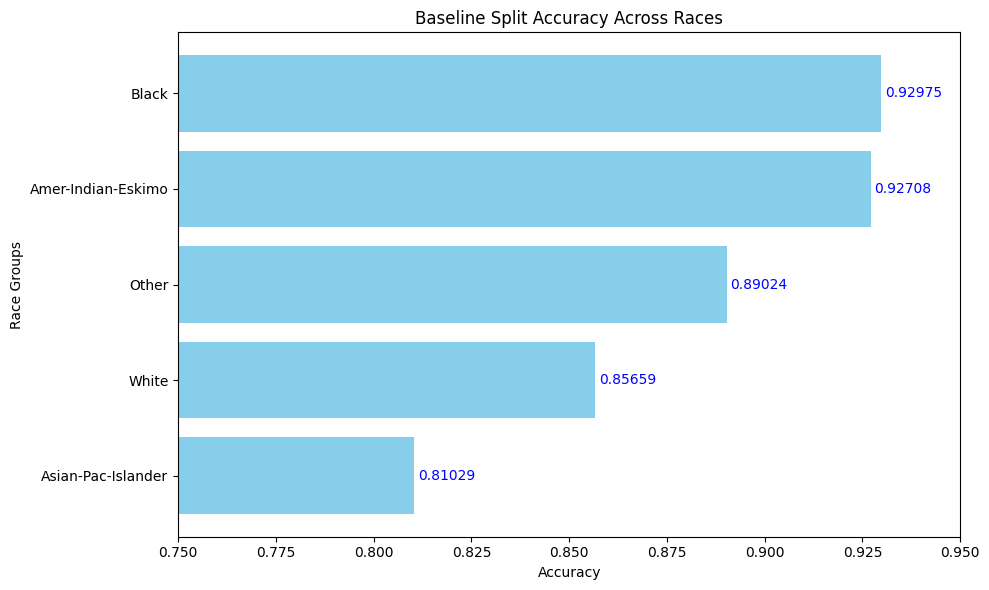

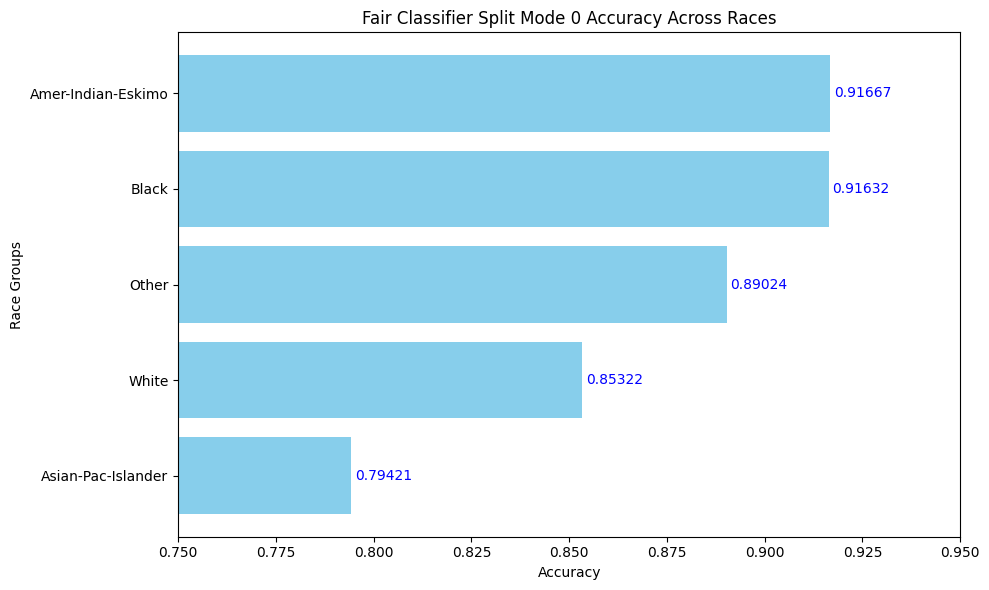

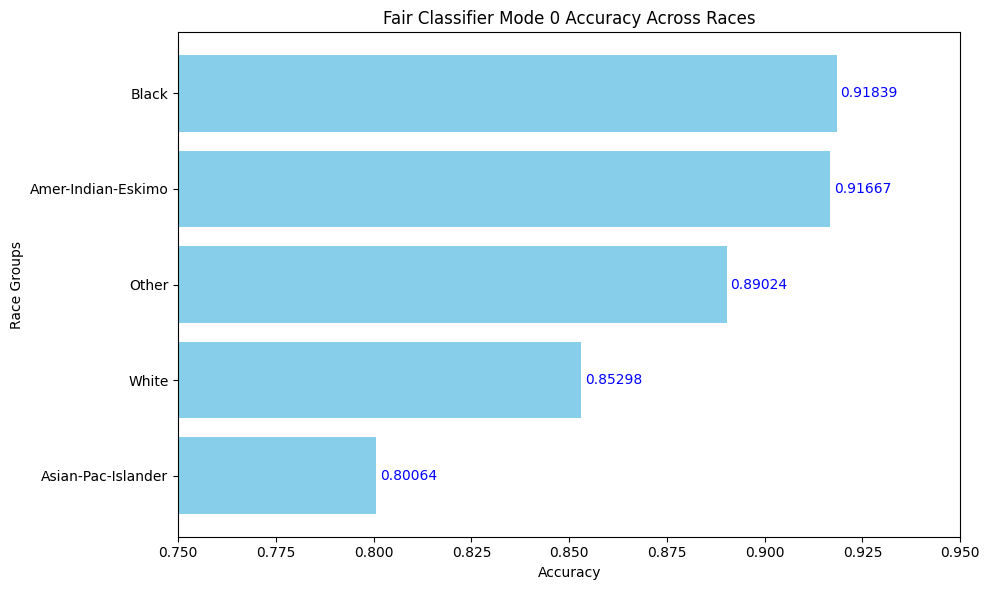

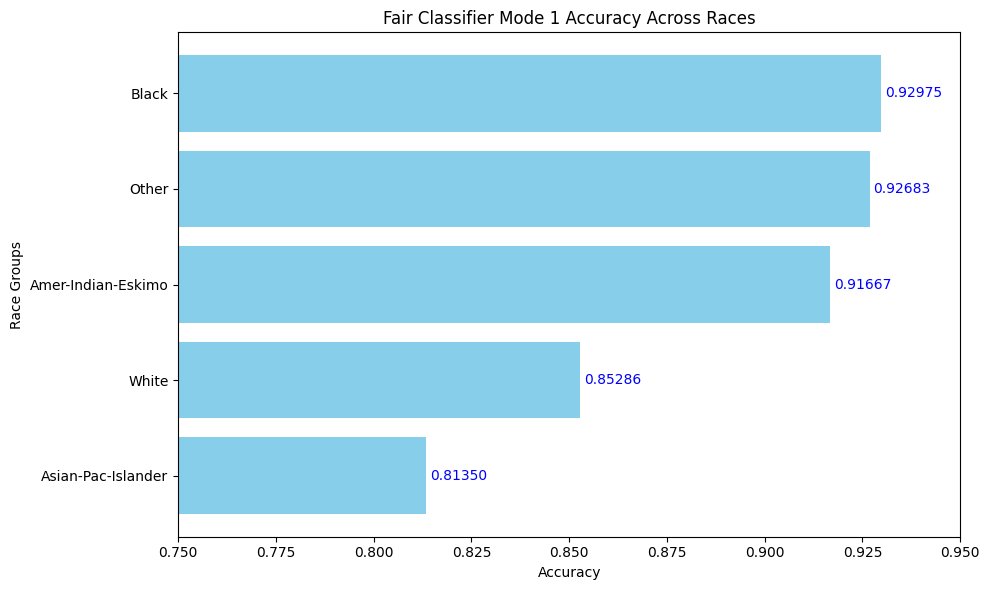

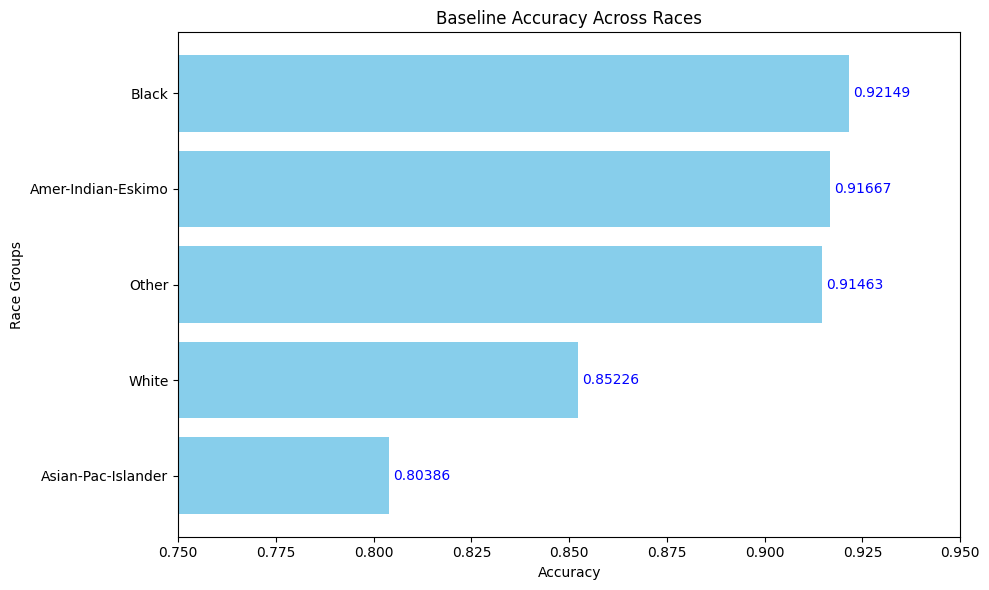

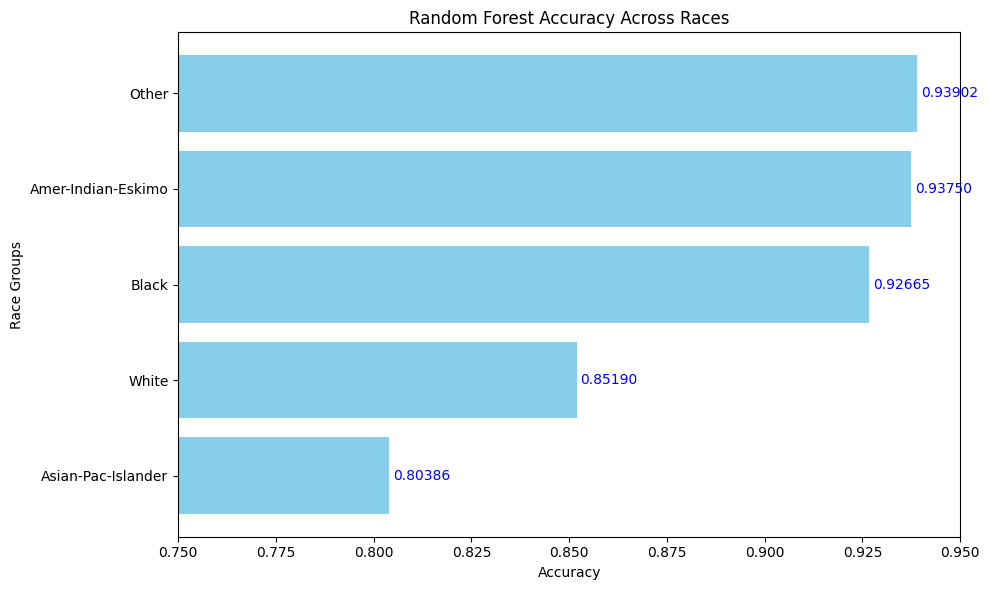

In [24]:
# Sort models by overall accuracy (from `accuracies`)
sorted_accuracies = sorted(accuracies.items(), key=lambda x: x[1], reverse=True)

# Extract the sorted model names based on overall accuracy
sorted_models = [item[0] for item in sorted_accuracies]

# Plot accuracies by race for each model in order of their overall accuracy
for model in sorted_models:
    # Get the accuracies for this model across all races from `results_df`
    model_accuracies = results_df[model]
    
    # Sort the accuracies in descending order (so the best race comes at the top)
    model_accuracies_sorted = model_accuracies.sort_values(ascending=False)
    
    # Create the bar chart for this model
    plt.figure(figsize=(10, 6))
    plt.barh(model_accuracies_sorted.index, model_accuracies_sorted.values, color="skyblue")
    plt.xlabel("Accuracy")
    plt.ylabel("Race Groups")
    plt.title(f"{model} Across Races")
    plt.xlim(0.75, 0.95)  # Limiting accuracy between 0.8 and 0.9
    
    # Annotate bars with accuracy values
    for i, v in enumerate(model_accuracies_sorted.values):
        plt.text(v + 0.001, i, f"{v:.5f}", color='blue', va='center')

    # Invert y-axis to show the highest accuracy at the top
    plt.gca().invert_yaxis()
    
    # Display the plot
    plt.tight_layout()
    plt.show()